In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.ndimage import gaussian_filter
BINS = 70

def occupancy_map(tracking = None, binnumber = BINS):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    occupancy = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    data_points = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            occupancy [x1,y1]= occupancy[x1,y1] + 1
            data_points+=1
    occupancy = occupancy/data_points
    return occupancy

def binned_tracking(tracking = None, binnumber = 70):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    
    xnew = [int(xpos[i]/xdenom) for i in range(len(xpos))]
    ynew = [int(ypos[i]/xdenom) for i in range(len(xpos))]
    
    return xnew,ynew

def neuron_activity_map(activity= None,tracking = None,binnumber = 70, neuronID = 0):
     
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[neuronID,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def mean_activity_map(activity= None,tracking = None,binnumber = BINS):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[:,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def speed_selection(tracking = None, speed_limit = 3):
    
    x = tracking[0,:]
    y = tracking[1,:]
    vx = np.diff(x)
    vy = np.diff(y)
    speed = np.sqrt(vx*vx+vy*vy)
    index = np.where(speed > speed_limit)[0]
    
    return index

def poisson_pdf(n,l):
    return pow(l,n)*exp(-l)/math.factorial(n)

In [811]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.
mouse = 411857    ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
session_now = 3
period = int(5 * sf / re_sf)
period_resting = period *50
fixed = 'None'
MIN_EVENT_DURATION = 2
## define task for plotting. This will cahnge for other mice!!!!

colorcodes = ['Greys','PuBu', 'YlOrRd','Reds','Blues','Oranges','Greens']
if mouse == 411857:
    sessions = [1,2,3]
    if session_now == 1:
        task = 'STABLE'
        colapse_behaviour = 2
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
    if session_now == 3:
        task = 'OVERLAPPING'
        fixed = 'LL'
        object_fixed = 3
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]   


if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            


In [812]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'

output_path =  os.environ['PROJECT_DIR'] +'neural_analysis/data/cc_pc_distance/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/trial_aligned_events/'

In [813]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
behaviour_list_copy = []
behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0
print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')

for trial in [1,6,11,16]:

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_' + f'{day+1}' + '_likelihood_0.75_ethogram_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        params.append(r2_params)
    resample_params = np.array(params)
        
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)

    behaviour_list.append(resample_beh1)
    behaviour_list_copy.append(resample_beh1.copy())
    parameters_list.append(resample_params)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]


    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                            '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

     ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

    activity_list.append(resample_neural_activity_mean)

    day = day + 1
    print(day)

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
1
2
3
4


In [814]:
    ## define targets of behaviour according to protocol (random, overlapping and stable)

    id_target = [0,1,2,3,4] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
    
    print('REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS')

    if colapse_behaviour == 0 : # RANDOM
        for day in range(len(behaviour_list)):
            for trial in range(5):
                behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
                objects = np.unique(behaviour_trial)
                selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                index0 = np.where(behaviour_trial==objects[selected_object])[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))[0]
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))[0]
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4            

                index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))[0]
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))[0]
                behaviour_trial[index0] = 0
                behaviour_trial[index1] = 0
                behaviour_trial[index2] = 0 

                behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


    if colapse_behaviour == 1 : #OVERLAPPING
        for day in range(len(behaviour_list)):
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
            behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 0        
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 0
            behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 0


    if colapse_behaviour == 2: #STABLE
        for day in range(len(behaviour_list)):
            objects = np.unique(behaviour_list[day])
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4      

            index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
            behaviour_list[day][index0] = 0
            behaviour_list[day][index1] = 0
            behaviour_list[day][index2] = 0  
    
    

REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [815]:
pca = PCA()
activity_list_pca = []
variance_list = []
variance_ratio_list = []

cca_components = min(9,activity_list[day].shape[0])
cca = CCA(n_components=cca_components)
activity_list_cca = []

for day in range(len(behaviour_list)):
    ### run pca on the entire dataset
    pca.fit(activity_list[day].T)
    transformed_activity = pca.fit(activity_list[day].T).transform(activity_list[day].T)
    activity_list_pca.append(transformed_activity.T)
    variance_list.append(pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2)
    normalized_variance = pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2
    variance_ratio_list.append(np.cumsum(normalized_variance/sum(normalized_variance)))
    activity_list_cca.append(cca.fit(activity_list[day].T, parameters_list[day].T).transform(activity_list[day].T))
    

In [816]:
# for each day creates a list that counts and saves times of different events.
events_day_list_1 = []
events_day_list_shuffle_1 = []

events_counter_day_list = []
events_time_starts_day = []

for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    random_events = []
    start_counter = 100
    counter = 0
    for i in range(behaviour_list[day].shape[0]):
        if behaviour_list[day][i] != start_counter and counter >  MIN_EVENT_DURATION:
            events_list.append(start_counter) # contains a sequence of events ID
            events_counter_list.append(counter) # conteins the duration of each event
            events_time_starts.append(i) # contains the time at which event starts
            start_counter = behaviour_list[day][i] 
            counter = 1
        else:
            counter = counter + 1    
            
    events_day_list_1.append(events_list)
    shufflings = []
    for j in range(10):
        shufflings.append(events_list.copy())
    events_day_list_shuffle_1.append(shufflings)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)


In [817]:
## compute events duration for type of event. Here we create lists that we can access to know the duration of each ID event
## we will use this to balance the dataset

events_duration_list = []
total_duration_list = []
number_of_events_list = []

for day in range(len(behaviour_list)):
    events_duration_day = []
    total_duration_day = []
    number_of_events_day = []
    for target in id_target:
        events = np.array(events_day_list_1[day])  # all events in a day
        events_counter = np.array(events_counter_day_list[day]) #duration of all day events
        events_time = np.array(events_time_starts_day[day]) # start time of events in day

        position_events = np.where(events == target)[0] # select events related to one specific ID
        events_duration_target = events_counter[position_events]   # take the duration of the events for that ID
        events_duration_day.append(events_duration_target)
        total_duration_day.append(np.sum(events_duration_target))
        number_of_events_day.append(len(events_duration_target ))
    events_duration_list.append(events_duration_day)
    total_duration_list.append(total_duration_day)
    number_of_events_list.append(number_of_events_day)

In [818]:
number_of_events_list

[[555, 672, 619, 76, 128],
 [478, 631, 564, 71, 126],
 [523, 710, 639, 63, 132],
 [484, 668, 597, 78, 111]]

In [819]:
### Balancing the number of events for selected targets 

selection_target = [3,4]    # here we balcance the data only for this targets of behaviour

events_day_list= []         # create a list with the selected index of the ID-list to make a balanced selection
events_day_list_shuffle = []
events_number_list = []
for day in range(len(behaviour_list)):
    
    arg_min_target_time = np.argmin(number_of_events_list[day])
    n_events = number_of_events_list[day][arg_min_target_time]
    events_number_list.append(n_events)
    events_list = []
    events_list_copy = []
    
    #print(n_events)
    for target in selection_target:
        sorted_events = np.sort(events_duration_list[day][target]) #sort of events
        arg_sorted_events = np.argsort(events_duration_list[day][target]) #take the index sorted by duration of events
        selected_events = arg_sorted_events[0:n_events]   # take only the first (sorter duration) events
        events_list.append(selected_events)                           # save the position of long and balanced events
        events_list_copy.append(selected_events.copy())               # make a copy of this events to create a shuffle list
        
    events_day_list.append(events_list)                              #this list contains index that are selected from the list of index of a specific target
    events_day_list_shuffle.append(events_list_copy)

In [820]:
print(events_day_list[0][0])

[ 0 71 21 62 58 74 53 40 31 42 56 52 51 43 28 30 17 18 32  8 13 41 63 16
 73 75  3  2  6 19 29 55  7 15 20  9 70 60 38 23 45 10 33 34 12 59 36 46
 49 68 11 61  5 67 35 27 48 44 54  1  4 39 64 22 69 14 57 72 24 37 66 50
 65 47 26 25]


In [821]:
### create shuffled behavioural labels that preserve balance and temporal structure
### the shuffling will be in visits or events (so we shuffle the labels of the complete event)

for day in range(len(behaviour_list)):
    events_shuffle = []
    events = np.array(events_day_list_1[day])
    events_counter = np.array(events_counter_day_list[day])
    events_time = np.array(events_time_starts_day[day])
    arg_min_target_time = np.argmin(number_of_events_list[day])
    n_events = number_of_events_list[day][arg_min_target_time]
    
    for target in range(len(selection_target)):
        all_events = np.where(events == target)[0]
        position_events = all_events[events_day_list[day][target]] # select the balanced data  
        events_shuffle.append(position_events)
    
    for j in range(10):
        counter_permutations = 0
        for i in range(n_events):
            permutation = np.random.permutation(len(selection_target))
            if permutation[0]!=0:
                counter_permutations +=1
                for index in range(len(selection_target)):
                    events_day_list_shuffle_1[day][j][events_shuffle[index][i]] = selection_target[permutation[index]]

In [822]:
events_day_list[0][0]

array([ 0, 71, 21, 62, 58, 74, 53, 40, 31, 42, 56, 52, 51, 43, 28, 30, 17,
       18, 32,  8, 13, 41, 63, 16, 73, 75,  3,  2,  6, 19, 29, 55,  7, 15,
       20,  9, 70, 60, 38, 23, 45, 10, 33, 34, 12, 59, 36, 46, 49, 68, 11,
       61,  5, 67, 35, 27, 48, 44, 54,  1,  4, 39, 64, 22, 69, 14, 57, 72,
       24, 37, 66, 50, 65, 47, 26, 25])

In [823]:
# figure1, axes1 = plt.subplots()

# figure2, axes2 = plt.subplots(2)

# #visits_counter = np.zeros(2,2)
# for day in range(len(behaviour_list)):
#     events = np.array(events_day_list_1[day])
#     events_shuffle = np.array(events_day_list_shuffle_1[day][1])
#     axes1.scatter(events[1:]+np.random.normal(0,0.1),events_shuffle[1:]+np.random.normal(0,0.1))
#     for target in [3,4]:
#         all_events = np.where(events == target)[0]
#         position_events = all_events[events_day_list[day][target]]
        
#         all_events_shuffle = np.where(events_shuffle == target)[0]
#         position_events_shuffle = all_events_shuffle[events_day_list_shuffle[day][target]]
        
#         axes2[target-3].scatter(position_events, position_events_shuffle)

# axes1.set_xlabel('Behaviour ID real data', fontsize =20)
# axes1.set_ylabel('Behaviour ID shuffle data', fontsize =20)

# axes2[0].set_xlabel('Time point Object1 Data', fontsize =20)
# axes2[0].set_ylabel('Time point Object1 Shuffle', fontsize =20)

# axes2[1].set_xlabel('Time point Object2 Data', fontsize =20)
# axes2[1].set_ylabel('Time point Object2 Shuffle', fontsize =20)

# figure2.set_size_inches(10,10)

In [824]:
#plt.scatter(events_day_list_shuffle_1[day][1][1:],events_day_list_shuffle_1[day][0][1:])


In [825]:
#len(list(set(position_events) & set(position_events_shuffle)))

In [826]:
## put all events together and take neural activity from each event
events_activity_pre_norm= []
events_duration_list = []
events_activity_pca = []
events_activity_cca = []


for day in range(len(behaviour_list)):
    target_activity = []
    target_activity_pca = []
    target_activity_cca = []
    events_duration_day = []
    for target in range(len(selection_target)):
        events = np.array(events_day_list_1[day])
        events_counter = np.array(events_counter_day_list[day])
        events_time = np.array(events_time_starts_day[day])

        all_events = np.where(events == target)[0]
        
        #print(all_events)
        #print(events_day_list[day][target])
        position_events = all_events[events_day_list[day][target]]
        
        events_duration = events_counter[position_events]   # convert to seconds
        time = events_time[position_events]
        i = 0
        event_target = []
        event_target_pca = []
        event_target_cca = []
        #events_duration_target = np.zeros(len(events_duration),)
        events_duration_target = []
        for event in events_duration:
            if event > 2:
                local_activity = activity_list[day][:,time[i]-period:time[i]+period]
                local_activity_pca = activity_list_pca[day][:,time[i]-period:time[i]+period]
                local_activity_cca = activity_list_cca[day][time[i]-period:time[i]+period,:].T
                event_target.append(local_activity)
                event_target_pca.append(local_activity_pca)
                event_target_cca.append(local_activity_cca)
                #events_duration_target[i]=1
                events_duration_target.append(events_duration[i])
            i = i + 1
        target_activity.append(event_target)
        target_activity_pca.append(event_target_pca)
        target_activity_cca.append(event_target_cca)
        events_duration_day.append(events_duration_target)
    events_activity_pre_norm.append(target_activity)
    events_duration_list.append(events_duration_day)
    events_activity_pca.append(target_activity_pca)
    events_activity_cca.append(target_activity_cca)

### same but with the events shuffle data

events_activity_pre_norm_shuffle= []
events_activity_pca_shuffle = []
events_activity_cca_shuffle = []


for day in range(len(behaviour_list)):
    
    shufflings = []
    shufflings_pca = []
    shufflings_cca = []
    for j in range(10):
        target_activity_shuffle = []
        target_activity_pca_shuffle = []
        target_activity_cca_shuffle = []
        events_duration_day_shuffle = []
        for target in range(len(selection_target)):
            events = np.array(events_day_list_shuffle_1[day][j])
            events_counter = np.array(events_counter_day_list[day])
            events_time = np.array(events_time_starts_day[day])

            all_events = np.where(events == target)[0]

            #print(all_events)
            #print(events_day_list[day][target])
            position_events = all_events[events_day_list_shuffle[day][target]]

            events_duration = events_counter[position_events]   # convert to seconds
            time = events_time[position_events]
            i = 0
            event_target = []
            event_target_pca = []
            event_target_cca = []
            #events_duration_target = np.zeros(len(events_duration),)
            events_duration_target = []
            for event in events_duration:
                if event > 2:
                    local_activity = activity_list[day][:,time[i]-period:time[i]+period]
                    local_activity_pca = activity_list_pca[day][:,time[i]-period:time[i]+period]
                    local_activity_cca = activity_list_cca[day][time[i]-period:time[i]+period,:].T
                    event_target.append(local_activity)
                    event_target_pca.append(local_activity_pca)
                    event_target_cca.append(local_activity_cca)
                    #events_duration_target[i]=1
                    events_duration_target.append(events_duration[i])
                i = i + 1
            target_activity_shuffle.append(event_target)
            target_activity_pca_shuffle.append(event_target_pca)
            target_activity_cca_shuffle.append(event_target_cca)
        shufflings.append(target_activity_shuffle)
        shufflings_pca.append(target_activity_pca_shuffle)
        shufflings_cca.append(target_activity_cca_shuffle)

    events_activity_pre_norm_shuffle.append(shufflings)
    events_activity_pca_shuffle.append(shufflings_pca)
    events_activity_cca_shuffle.append(shufflings_cca)

events_activity = events_activity_pre_norm

In [827]:
    
#     ### Select a cell
#     day = 0
#     #for NEURON in range(100):
#     NEURON = 0
#     figure = plt.figure()
#     gs = plt.GridSpec(15, 3)

#     shuffle_used = 4
#     axes = figure.add_subplot(gs[1:3, 0:3])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),activity_list[day][NEURON,:],color = 'k')
#     axes.set_xlabel('Time(s)',fontsize = 15)
#     axes.set_ylabel('Activity',fontsize = 15)

#     axes = figure.add_subplot(gs[0, 0:3])
#     behaviour1 = np.zeros((len(behaviour_list[day]),))
#     behaviour1[np.where(behaviour_list[day]==3)[0]] = np.max(activity_list[day][NEURON,:])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'r')
#     behaviour1 = np.zeros((len(behaviour_list[day]),))
#     behaviour1[np.where(behaviour_list[day]==4)[0]] = np.max(activity_list[day][NEURON,:])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'b')
#     axes.set_ylabel('Behaviour',fontsize = 15)
#     axes.legend(['Obj1','Obj2'])


#     color_code = ['Reds','Blues']
#     j = 1
#     for target in selection_target:
#         axes = figure.add_subplot(gs[4:10, j])
#         color = events_duration_list[day][target]
#         neuron_trial_activity = np.zeros((len(events_activity_pre_norm_shuffle[day][shuffle_used][target]),events_activity_pre_norm_shuffle[day][shuffle_used][3][0].shape[1]))
#         for trial in range(len(events_activity_pre_norm_shuffle[day][shuffle_used][target])):
#             if len( events_activity_pre_norm_shuffle[day][shuffle_used][target][trial][NEURON,:]):
#                 neuron_trial_activity[trial,:] = events_activity_pre_norm_shuffle[day][shuffle_used][target][trial][NEURON,:]
            
#         C_0 = neuron_trial_activity.copy()
#         time_axis = np.arange(-period,period)/10
#         neurons_axis = np.arange(0,C_0.shape[0])
#         print(C_0.shape)
#         mesh = axes.pcolormesh(time_axis,neurons_axis, C_0, cmap=color_code[j-1],shading='auto')
            
#  #         for i in range(0, len(C_0)):
# #             #C_0[i] += C_0[i].min() + C_0[:i].max()
# #             C_0[i]= C_0[i]/(C_0[i].max()-C_0[i].min()) + i
# #             if color[i]==1:
# #                 axes.plot(np.arange(-period,period)/10,C_0[i],color_code[j-1])
# #             else:
# #                 axes.plot(np.arange(-period,period)/10,C_0[i],'k')
#         #axes.set_xlabel('Time [s]',fontsize = 15)
    
#         axes.set_yticks([])
#         axes.set_ylabel('Trials (events)', fontsize = 15)
#         axes.set_title('target:' + f'{target}', fontsize = 20)
#         axes.vlines(0,0, C_0.shape[0], color = 'k')
        
#         axes_1 = figure.add_subplot(gs[11:13, j])
#         pstd = np.mean(neuron_trial_activity,axis = 0)
#         time_axis = np.arange(-period,period)/10
#         axes_1.plot(time_axis, pstd,'k', linewidth = 2)
#         axes_1.set_title('PSTD', fontsize = 15)
#         axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
#         axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)

#         axes_1 = figure.add_subplot(gs[13:15, j])
#         pstd_std = np.std(neuron_trial_activity,axis = 0)
#         uperbound = pstd + pstd_std
#         lowerbound = pstd - pstd_std
#         time_axis = np.arange(-period,period)/10
#         axes_1.plot(time_axis, pstd,'k', linewidth = 2)
#         axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
#         axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
#         axes_1.set_xlabel('Time [s]',fontsize = 15)
#         axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)
#         j=j+1


#     sigma = 1.5
#     occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
#     activity_map_variable = neuron_activity_map(activity_list[day],tracking_list[day], binnumber = BINS, neuronID = NEURON)
#     normalized_activity_map = np.zeros_like(activity_map_variable)
#     normalized_activity_map[np.where(occupancy)] = activity_map_variable[np.where(occupancy)]/occupancy[np.where(occupancy)]
    
#     occupancy = gaussian_filter(occupancy, sigma)
#     activity_map_variable = gaussian_filter(activity_map_variable, sigma)
#     normalized_activity_map = gaussian_filter(normalized_activity_map,sigma)
    
#     axes0 = figure.add_subplot(gs[3:7,0])
#     axes1 = figure.add_subplot(gs[7:11, 0])
#     axes2 = figure.add_subplot(gs[11:15, 0])

#     axes0.imshow(occupancy, cmap = 'jet')
#     axes0.set_ylabel('Occupancy', fontsize = 15)
#     axes1.imshow(activity_map_variable, cmap='jet')
#     axes1.set_ylabel('Mean activity',fontsize = 15)
#     axes2.imshow(normalized_activity_map, cmap = 'jet')
#     axes2.set_ylabel('Mean activity / Occupancy', fontsize = 15)
    
    
#     #axes = figure.add_subplot(gs[3:10,0])
#     #axes.imshow(activity_map_variable, cmap='jet')
#     #axes.set_title('Mean Spatial Neural activity')

#     figure.set_size_inches([30., 15])

#     figure.suptitle(' Traces events plot ' + task +' NEURON: '+f'{NEURON}'+'_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
#     figure_name = figure_path + 'neurons/'+'traces_events_neuron_'+f'{NEURON}'+'_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
#                                  '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_shuffle.png'
#     figure.savefig(figure_name)
#     #plt.close()


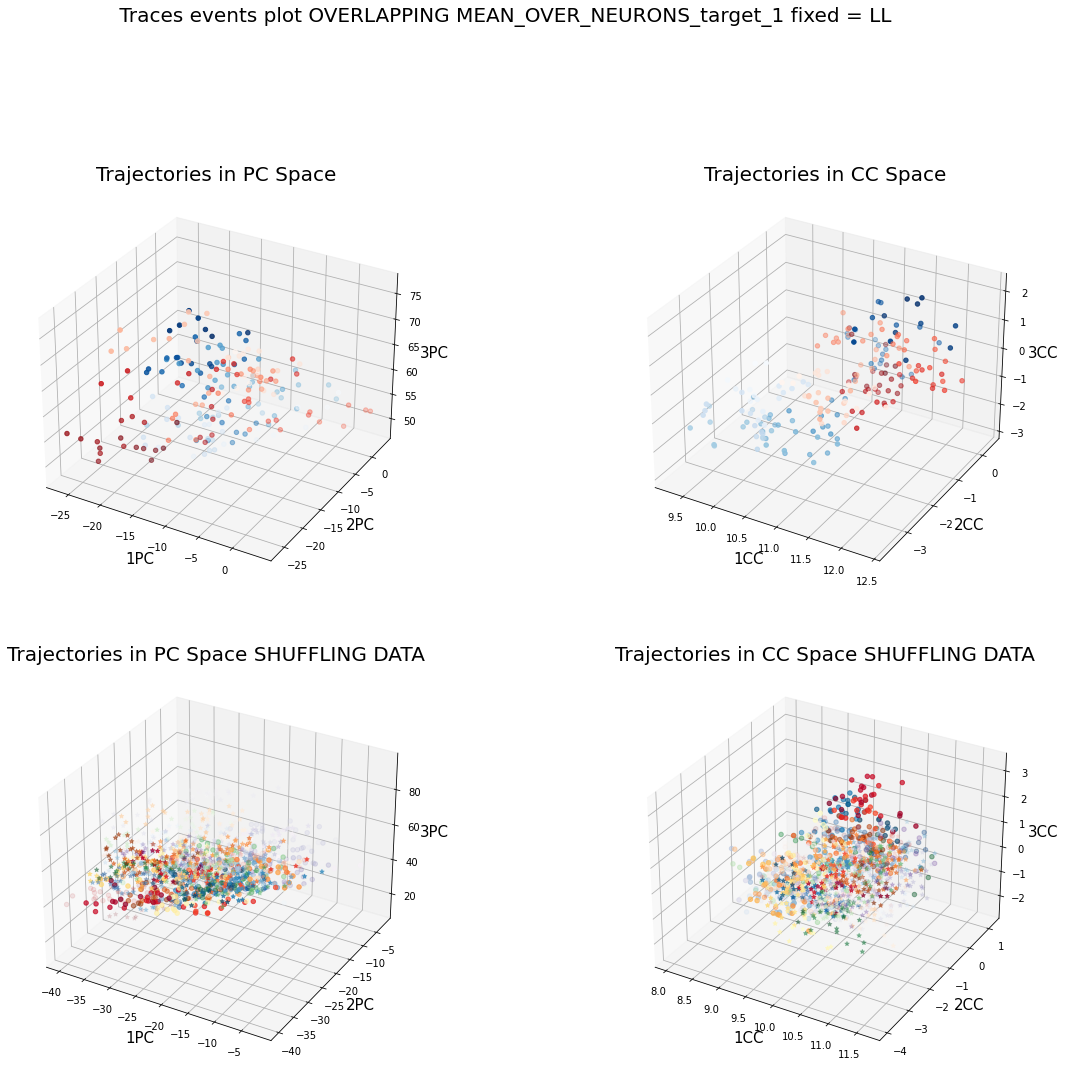

In [867]:
day = 0
behaviour = ['Object1','Object2']
figure = plt.figure()
gs = plt.GridSpec(3, 2)

color_code = ['Reds','Blues']
    
axes_pc_trajectory = figure.add_subplot(gs[0,0],projection = '3d')
axes_pc_trajectory.set_title('Trajectories in PC Space', fontsize = 20)
axes_pc_trajectory.set_xlabel('1PC',fontsize = 15)
axes_pc_trajectory.set_ylabel('2PC',fontsize = 15)
axes_pc_trajectory.set_zlabel('3PC',fontsize = 15)
# axes_pc_trajectory.set_xlim([-4,-2])
# axes_pc_trajectory.set_ylim([-4,-2])
# axes_pc_trajectory.set_zlim([-1,1])

axes_cc_trajectory = figure.add_subplot(gs[0,1],projection = '3d')
axes_cc_trajectory.set_title('Trajectories in CC Space', fontsize = 20)
axes_cc_trajectory.set_xlabel('1CC',fontsize = 15)
axes_cc_trajectory.set_ylabel('2CC',fontsize = 15)
axes_cc_trajectory.set_zlabel('3CC',fontsize = 15)
# axes_cc_trajectory.set_xlim([-7,-3])
# axes_cc_trajectory.set_ylim([-2,-0])
# axes_cc_trajectory.set_zlim([2,3]) 
    
j=0 
for target in range(len(selection_target)):
    # real data! 
    trial_activity = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
    trial_activity_complete = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*10+1))
    trial_activity_all_data = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*2*period+1))
    trial_activity_pca = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
    trial_activity_cca = np.zeros((cca_components,events_activity[day][target][0].shape[1]))
       
    ### generate matrix with mean activity and entire trial repetitions activity
    for neuron in range(events_activity[day][target][0].shape[0]):
        neuron_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
        component_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
        cca_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
        init = 0
        init2=0
        for trial in range(len(events_activity[day][target])):
            if len(events_activity[day][target][trial][neuron,:]):
                neuron_trial_activity += events_activity[day][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
                component_trial_activity +=events_activity_pca[day][target][trial][neuron,:]
                if neuron < cca_components:
                    cca_trial_activity +=events_activity_cca[day][target][trial][neuron,:]
                trial_activity_all_data[neuron,init2:init2+2*period]= events_activity[day][target][trial][neuron,:]
                trial_activity_complete[neuron,init:init+10] = events_activity[day][target][trial][neuron,period:period+10]
                init = init+10
                init2=init2+2*period
        neuron_trial_activity = neuron_trial_activity / len(events_activity[day][target])
        component_trial_activity = component_trial_activity / len(events_activity[day][target])
        trial_activity[neuron,:] = neuron_trial_activity
        trial_activity_pca[neuron,:] = component_trial_activity
        if neuron < cca_components:
            trial_activity_cca[neuron,:] = cca_trial_activity / cca_components
    color = np.linspace(0, 20, 2*period)
    axes_pc_trajectory.scatter(trial_activity_pca[1,:],trial_activity_pca[1,:],trial_activity_pca[2,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
    axes_cc_trajectory.scatter(trial_activity_cca[0,:],trial_activity_cca[1,:],trial_activity_cca[2,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
    j = j + 1

color_code = ['Greys', 'Reds', 'Purples', 'Blues', 'Greens', 'Oranges', 'PuBu', 'YlOrRd']
markers = ['*', 'o']
axes_pc_trajectory = figure.add_subplot(gs[1,0],projection = '3d')
axes_pc_trajectory.set_title('Trajectories in PC Space SHUFFLING DATA', fontsize = 20)
axes_pc_trajectory.set_xlabel('1PC',fontsize = 15)
axes_pc_trajectory.set_ylabel('2PC',fontsize = 15)
axes_pc_trajectory.set_zlabel('3PC',fontsize = 15)
# axes_pc_trajectory.set_xlim([-4,-2])
# axes_pc_trajectory.set_ylim([-4,-2])
# axes_pc_trajectory.set_zlim([-1,1])

axes_cc_trajectory = figure.add_subplot(gs[1,1],projection = '3d')
axes_cc_trajectory.set_title('Trajectories in CC Space SHUFFLING DATA', fontsize = 20)
axes_cc_trajectory.set_xlabel('1CC',fontsize = 15)
axes_cc_trajectory.set_ylabel('2CC',fontsize = 15)
axes_cc_trajectory.set_zlabel('3CC',fontsize = 15)
# axes_cc_trajectory.set_xlim([-7,-3])
# axes_cc_trajectory.set_ylim([-2,-0])
# axes_cc_trajectory.set_zlim([2,3]) 

for shuffle in range(8):
    j=0
  
    for target in range(len(selection_target)):
        
        trial_activity = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[0],events_activity_pre_norm_shuffle[day][shuffle ][target][0].shape[1]))
        trial_activity_complete = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[0],len(events_activity_pre_norm_shuffle[day][shuffle][target])*10+1))
        trial_activity_all_data = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[0],len(events_activity_pre_norm_shuffle[day][shuffle][target])*2*period+1))
        trial_activity_pca = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[0],events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[1]))
        trial_activity_cca = np.zeros((cca_components,events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[1]))
       
        ### generate matrix with mean activity and entire trial repetitions activity
        for neuron in range(events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[0]):
            neuron_trial_activity = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[1],))
            component_trial_activity = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[1],))
            cca_trial_activity = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[1],))
            init = 0
            init2=0
            for trial in range(len(events_activity_pre_norm_shuffle[day][shuffle][target])):
                if len(events_activity_pre_norm_shuffle[day][shuffle][target][trial][neuron,:]):
                    neuron_trial_activity += events_activity_pre_norm_shuffle[day][shuffle][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
                    component_trial_activity +=events_activity_pca_shuffle[day][shuffle][target][trial][neuron,:]
                    if neuron < cca_components:
                        cca_trial_activity +=events_activity_cca_shuffle[day][shuffle][target][trial][neuron,:]
                    trial_activity_all_data[neuron,init2:init2+2*period]= events_activity_pre_norm_shuffle[day][shuffle][target][trial][neuron,:]
                    trial_activity_complete[neuron,init:init+10] = events_activity_pre_norm_shuffle[day][shuffle][target][trial][neuron,period:period+10]
                    init = init+10
                    init2=init2+2*period
            neuron_trial_activity = neuron_trial_activity / len(events_activity_pre_norm_shuffle[day][shuffle][target])
            component_trial_activity = component_trial_activity / len(events_activity_pre_norm_shuffle[day][shuffle][target])
            trial_activity[neuron,:] = neuron_trial_activity
            trial_activity_pca[neuron,:] = component_trial_activity
            if neuron < cca_components:
                trial_activity_cca[neuron,:] = cca_trial_activity / cca_components
        
    
        color = np.linspace(0, 20, 2*period)
        axes_pc_trajectory.scatter(trial_activity_pca[1,:],trial_activity_pca[1,:],trial_activity_pca[2,:], c = color, cmap = color_code[shuffle], marker =markers[j], alpha = shuffle*0.1)
        axes_cc_trajectory.scatter(trial_activity_cca[0,:],trial_activity_cca[1,:],trial_activity_cca[2,:], c = color, cmap = color_code[shuffle], marker = markers[j], alpha = shuffle*0.1)
        
        
        j=j+1
    

    figure.set_size_inches([20., 25])

    figure.suptitle(' Traces events plot ' + task +' MEAN_OVER_NEURONS_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    figure_name = figure_path + 'shufflings/'+'Dim_reduced_space_average_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'.png'
    figure.savefig(figure_name)
    #plt.close()
    


In [868]:
target

1

In [869]:
### Select a cell
behaviour = ['Object1','Object2']
#figure = plt.figure()
#gs = plt.GridSpec(3, 2)

color_code = ['Reds','Blues']

trial_activity_vectors = np.zeros((len(selection_target),events_activity[day][0][0].shape[0],events_activity[day][0][0].shape[1]))
trial_activity_pca_vectors = np.zeros((len(selection_target),events_activity[day][0][0].shape[0],events_activity[day][0][0].shape[1]))
trial_activity_cca_vectors = np.zeros((len(selection_target),cca_components,events_activity[day][0][0].shape[1]))    j = j + 1


j=0 
for target in range(len(selection_target)):
    # real data! 
    trial_activity = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
    trial_activity_complete = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*10+1))
    trial_activity_all_data = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*2*period+1))
    trial_activity_pca = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
    trial_activity_cca = np.zeros((cca_components,events_activity[day][target][0].shape[1]))
       
    ### generate matrix with mean activity and entire trial repetitions activity
    for neuron in range(events_activity[day][target][0].shape[0]):
        neuron_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
        component_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
        cca_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
        init = 0
        init2=0
        for trial in range(len(events_activity[day][target])):
            if len(events_activity[day][target][trial][neuron,:]):
                neuron_trial_activity += events_activity[day][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
                component_trial_activity +=events_activity_pca[day][target][trial][neuron,:]
                if neuron < cca_components:
                    cca_trial_activity +=events_activity_cca[day][target][trial][neuron,:]
                trial_activity_all_data[neuron,init2:init2+2*period]= events_activity[day][target][trial][neuron,:]
                trial_activity_complete[neuron,init:init+10] = events_activity[day][target][trial][neuron,period:period+10]
                init = init+10
                init2=init2+2*period
        neuron_trial_activity = neuron_trial_activity / len(events_activity[day][target])
        component_trial_activity = component_trial_activity / len(events_activity[day][target])
        trial_activity[neuron,:] = neuron_trial_activity
        trial_activity_pca[neuron,:] = component_trial_activity
        if neuron < cca_components:
            trial_activity_cca[neuron,:] = cca_trial_activity / cca_components
    color = np.linspace(0, 20, 2*period)
    #axes_pc_trajectory.scatter(trial_activity_pca[1,:],trial_activity_pca[1,:],trial_activity_pca[2,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
    #axes_cc_trajectory.scatter(trial_activity_cca[0,:],trial_activity_cca[1,:],trial_activity_cca[2,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
    trial_activity_vectors[j,:,:] = trial_activity
    trial_activity_pca_vectors[j,:,:] = trial_activity_pca
    trial_activity_cca_vectors[j,:,:] = trial_activity_cca[:cca_components,:]
                                  
    j = j + 1

In [870]:
distance_pca = np.zeros((trial_activity_vectors.shape[2],))
distance_cca = np.zeros((trial_activity_vectors.shape[2],))

for time in range(trial_activity_vectors.shape[2]):
    distance_pca[time] = np.linalg.norm(trial_activity_pca_vectors[0,:,time] - trial_activity_pca_vectors[1,:,time])
    distance_cca[time] = np.linalg.norm(trial_activity_cca_vectors[0,:,time] - trial_activity_cca_vectors[1,:,time])
   

In [871]:
# figure, axes = plt.subplots()
# print(period)
# axes.plot(np.arange(-period,period)/10, distance_pca)
# axes.set_ylabel('Euclidean Distance', fontsize = 20)
# axes.set_xlabel('Time (s)', fontsize = 20)
# axes.vlines(0,2.2,2.5, 'k')

# figure.suptitle(' Distance in PCA ob objects representation' + task + ' fixed = ' + fixed   , fontsize = 20)
# figure_name = figure_path+ 'distance_mean_representations/' + 'distance_pca_object_representation_'+f'{mouse}'+'_session_'+f'{session}'+\
#                                  '_day_'+f'{day}'+'.png'
# figure.savefig(figure_name)

In [872]:
# figure, axes = plt.subplots()

# axes.plot(np.arange(-period,period)/10, distance_cca)
# axes.set_ylabel('Euclidean Distance', fontsize = 20)
# axes.set_xlabel('Time (s)', fontsize = 20)
# axes.vlines(0,3,5.5, 'k')


# figure.suptitle(' Distance in CCA ob objects representation' + task + ' fixed = ' + fixed   , fontsize = 20)
# figure_name = figure_path +'distance_mean_representations/'+ 'distance_cca_object_representation_'+f'{mouse}'+'_session_'+f'{session}'+\
#                                  '_day_'+f'{day}'+'.png'
# figure.savefig(figure_name)

In [873]:

trial_activity_vectors_shuffle = np.zeros((10,len(selection_target),events_activity[day][0][0].shape[0],events_activity[day][0][0].shape[1]))
trial_activity_pca_vectors_shuffle = np.zeros((10,len(selection_target),events_activity[day][0][0].shape[0],events_activity[day][0][0].shape[1]))
trial_activity_cca_vectors_shuffle = np.zeros((10,len(selection_target),cca_components,events_activity[day][0][0].shape[1]))

for shuffle in range(8):
    j=0
  
    for target in range(len(selection_target)):
        
        trial_activity = np.zeros((events_activity_pre_norm_shuffle[day][shuffle ][target][0].shape[0],events_activity_pre_norm_shuffle[day][shuffle ][target][0].shape[1]))
        trial_activity_complete = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[0],len(events_activity_pre_norm_shuffle[day][shuffle][target])*10+1))
        trial_activity_all_data = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[0],len(events_activity_pre_norm_shuffle[day][shuffle][target])*2*period+1))
        trial_activity_pca = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[0],events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[1]))
        trial_activity_cca = np.zeros((cca_components,events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[1]))
       
        ### generate matrix with mean activity and entire trial repetitions activity
        for neuron in range(events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[0]):
            neuron_trial_activity = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[1],))
            component_trial_activity = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[1],))
            cca_trial_activity = np.zeros((events_activity_pre_norm_shuffle[day][shuffle][target][0].shape[1],))
            init = 0
            init2=0
            for trial in range(len(events_activity_pre_norm_shuffle[day][shuffle][target])):
                if len(events_activity_pre_norm_shuffle[day][shuffle][target][trial][neuron,:]):
                    neuron_trial_activity += events_activity_pre_norm_shuffle[day][shuffle][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
                    component_trial_activity +=events_activity_pca_shuffle[day][shuffle][target][trial][neuron,:]
                    if neuron < cca_components:
                        cca_trial_activity +=events_activity_cca_shuffle[day][shuffle][target][trial][neuron,:]
                    trial_activity_all_data[neuron,init2:init2+2*period]= events_activity_pre_norm_shuffle[day][shuffle][target][trial][neuron,:]
                    trial_activity_complete[neuron,init:init+10] = events_activity_pre_norm_shuffle[day][shuffle][target][trial][neuron,period:period+10]
                    init = init+10
                    init2=init2+2*period
            neuron_trial_activity = neuron_trial_activity / len(events_activity_pre_norm_shuffle[day][shuffle][target])
            component_trial_activity = component_trial_activity / len(events_activity_pre_norm_shuffle[day][shuffle][target])
            trial_activity[neuron,:] = neuron_trial_activity
            trial_activity_pca[neuron,:] = component_trial_activity
            if neuron < cca_components:
                trial_activity_cca[neuron,:] = cca_trial_activity / cca_components
        
        trial_activity_vectors_shuffle[shuffle,j,:,:] = trial_activity
        trial_activity_pca_vectors_shuffle[shuffle,j,:,:] = trial_activity_pca
        trial_activity_cca_vectors_shuffle[shuffle,j,:,:] = trial_activity_cca[:cca_components,:]

        j=j+1
    

In [874]:
distance_pca_shuffle = np.zeros((10,trial_activity_vectors.shape[2],))
distance_cca_shuffle = np.zeros((10,trial_activity_vectors.shape[2],))

for shuffle in range(10):
    for time in range(trial_activity_vectors.shape[2]):
        distance_pca_shuffle[shuffle,time] = np.linalg.norm(trial_activity_pca_vectors_shuffle[shuffle,0,:,time] - trial_activity_pca_vectors_shuffle[shuffle,1,:,time])
        distance_cca_shuffle[shuffle,time] = np.linalg.norm(trial_activity_cca_vectors_shuffle[shuffle,0,:,time] - trial_activity_cca_vectors_shuffle[shuffle,1,:,time])


In [875]:
distance_pca_mean = np.mean(distance_pca_shuffle,axis=0)
distance_cca_mean = np.mean(distance_cca_shuffle,axis=0)

distance_pca_std = np.std(distance_pca_shuffle,axis=0)
distance_cca_std = np.std(distance_cca_shuffle,axis=0)

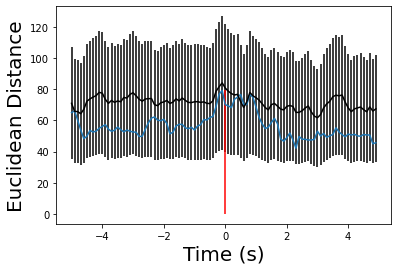

In [876]:
figure, axes = plt.subplots()

axes.plot(np.arange(-period,period)/10, distance_pca)
axes.errorbar(np.arange(-period,period)/10, distance_pca_mean, distance_pca_std, color = 'k')
axes.set_ylabel('Euclidean Distance', fontsize = 20)
axes.set_xlabel('Time (s)', fontsize = 20)
axes.vlines(0,0,max( distance_pca), 'r')

# figure.suptitle(' Distance in PCA of objects representation' + task + ' fixed = ' + fixed   , fontsize = 20)
# figure_name = figure_path + 'distance_mean_representations/'+'distance_pca_object_representation_'+f'{mouse}'+'_session_'+f'{session}'+\
#                                  '_day_'+f'{day}'+'.png'
# figure.savefig(figure_name)

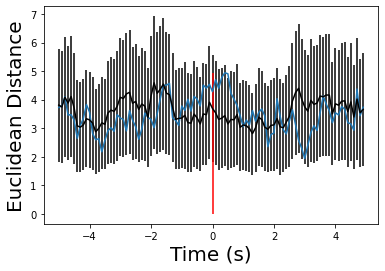

In [877]:
figure, axes = plt.subplots()

axes.plot(np.arange(-period,period)/10, distance_cca)
axes.errorbar(np.arange(-period,period)/10, distance_cca_mean, distance_cca_std, color = 'k')
axes.set_ylabel('Euclidean Distance', fontsize = 20)
axes.set_xlabel('Time (s)', fontsize = 20)
axes.vlines(0,0,max( distance_cca), 'r')


# figure.suptitle(' Distance in CCA of objects representation' + task + ' fixed = ' + fixed   , fontsize = 20)
# figure_name = figure_path +'distance_mean_representations/'+ 'distance_cca_object_representation_'+f'{mouse}'+'_session_'+f'{session}'+\
#                                  '_day_'+f'{day}'+'.png'
# figure.savefig(figure_name)

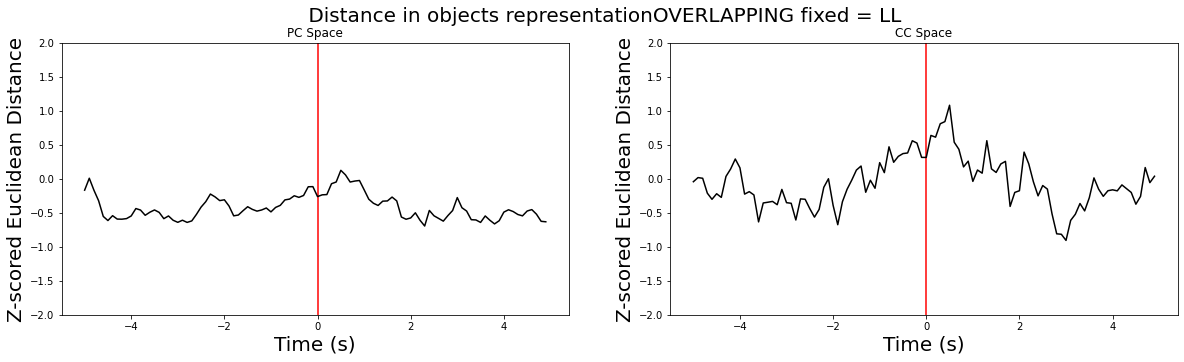

In [878]:
figure, axes = plt.subplots(1,2)

z_scored_pca = (distance_pca - distance_pca_mean)/distance_pca_std
axes[0].plot(np.arange(-period,period)/10, z_scored_pca, color = 'k')
axes[0].set_ylabel('Z-scored Euclidean Distance', fontsize = 20)
axes[0].set_xlabel('Time (s)', fontsize = 20)
axes[0].vlines(0,-2,2, 'r')
axes[0].set_title('PC Space')
axes[0].set_ylim([-2,2])

z_scored_cca = (distance_cca - distance_cca_mean)/ distance_cca_std
axes[1].plot(np.arange(-period,period)/10, z_scored_cca , color = 'k')
axes[1].set_ylabel('Z-scored Euclidean Distance', fontsize = 20)
axes[1].set_xlabel('Time (s)', fontsize = 20)
axes[1].vlines(0,-2,2, 'r')
axes[1].set_title('CC Space')
axes[1].set_ylim([-2,2])

figure.set_size_inches(20,5)

figure.suptitle(' Distance in objects representation' + task + ' fixed = ' + fixed   , fontsize = 20)
figure_name = figure_path +'distance_mean_representations/'+ 'distance_object_representation_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'.png'
figure.savefig(figure_name)

In [879]:
file_name_pca = output_path  +'pca_mouse_'+f'{mouse}'+'_session_'+f'{session}'+ '_day_'+f'{day}'
np.save(file_name_pca, z_scored_pca)
file_name_cca = output_path +'cca_mouse_'+f'{mouse}'+'_session_'+f'{session}'+ '_day_'+f'{day}'
np.save(file_name_cca, z_scored_cca)